# Introduction to Probabilistic Programming 

Probabilistic programming is a method for Bayesian statistical analysis. Bayesian methods, in contrast to Frequentist statistics, do not believe that the data represents the entire truth about the world. Instead, Bayesian methods are model based meaning there is a prior probability which is updated with more information. This is captured in the famous Bayes' Rule.

$$P(Y | X) = \frac{P(X | Y) * P (Y)}{P(X)}$$

Where 
* $P(Y | X)$: posterior probability of Y conditioned on the value of X - what we want to figure out, 
* $(P X | Y)$: likelihood - the observed data
* $P(Y)$: prior - probability of Y given no observations, also known as the base rate
* $P(X)$: marginal probability of X - total probability of X for all values of Y

In the case where both X and Y are Bernoulli variables (can only take on True / False values), then the marginal probability of X is 

$$P(X) = P(X | Y) * P(Y) + P(X | \neg Y) * P(\neg Y)$$

where $\neg$ means "not". 


I don't tend to get much value from equations, so let's plug in some numbers into an example of determining if a 
transaction is fraudulent considering only whether or not the amount of the transactions > $500.

Here are the relevant pieces:

$$P(\text{Fraudulent} | \text{Amount > \$500}) = \frac{P(\text{Amount > \$500} | \text{Fraudulent}) * P(\text{Fraudulent})}{P(\text{Amount > \$500})}$$

* $P(\text{Fraudulent} | \text{Amount > \$500})$: unknown posterior- what we want to find out
* $P(\text{Amount > \$500} | \text{Fraudulent}) = 0.6$: likelihood based on past observations
* $P(\text{Fraudulent}) = 0.01)$: prior probability of a fraudulent transaction

The marginal probability of a transaction greater than \$500 is must take into account both the situation where the transaction is fraudulent and the situation where the transaction is not fraudulent. 

* $P(\text{Amount} > \$500) = P(\text{Amount > \$500} | \text{Fraudulent}) * P(\text{Fraudulent}) + P(\text{Amount > \$500} | \neg \text{Fraudulent}) * P(\neg \text{Fraudulent})$

This means we need $P(\text{Amount > \$500} | \neg \text{Fraudulent})$ which also must be found from the historical data. Let's say this is 0.2 

We now have all the pieces and can carry out the calculation. 

$$P(\text{Fraudulent} | \text{Amount > \$500}) = \frac{0.6 * 0.01}{(0.6 * 0.01) + (0.2 * 0.99)} = 0.0294 = 2.94\%$$ 

This is the _posterior_ probability of a fraudulent transaction _conditioned_ on the amount of the transaction greater than \$500. The model we created for fraud is extremely simple - there is only one cause for fraud, the amount of the transaction. What happens when we have multiple causes, each of which in turn may have their own cause? For this, we turn to Bayesian graphical models which allow us to show the cause and effect relationship between variables as well as the associated probabilities. 

### Bayesian Graphical Model

The model below is a slightly more complex simulation of fraud. Here, fraud has two causes, if the transaction is greater than \$500, and if the transaction was made online. For now, we are still using only Bernoulli (True / False) variables in our model. A variable that does not have any causes has a prior probability as indicated by the blue tables. Variables that are dependent on other variables have a conditional probability table in orange. The conditional probability table specifies the probability of the dependent variable for all the values of its _parent_ variables. 



![](../images/fraud_model.png)

Once we have the model, we can figure out the posterior probability of any variable given any combination of the other variables. For example, to find the marginal probability of an online transaction, we need to sum up the probability for each combination of the parent variables.

$$P(Online) = P(Online | Location, Gender) * P(Location) * P(Gender) + P(Online| Location, \neg Gender) * P(Location) * P(\neg Gender) + P(Online | \neg Location, Gender) * P(\neg Location) * P(Gender) + P(Online | \neg Location, \neg Gender) * P(\neg Location) * P(\neg Gender)$$

Plugging in the numbers we get: $P(Online) = 0.25 * 0.2 * 0.5 + 0.45 * 0.2 * 0.5 + 0.3 * 0.8 * 0.5 + 0.6 * 0.8 * 0.5 = 0.43$

That's a lot of work! We can do a similar operation for a fraudulent transaction and compute the marginal probability:

$$P(Fraud) = 0.45 * 0.1 * 0.43 + 0.2 * 0.1 * 0.57 + 0.1 * 0.9 * 0.43 + 0.05 * 0.9 * 0.57 = 0.10518$$

Here we see that the probability of a fraudulent transaction knowing known of the other variables is 10.5%. 

We can also set variables to be fixed and then compute the probabilities. If we set the amount to be less than \$500, then the marginal probability of a fraudulent transaction is 

$$P(Fraud | Amount) = 0.1 * 1.0 * 0.43 + 0.05 * 1.0 * 0.57 = 0.07635$$

The probability we compute has dropped because we have additional evidence. 

Computing these probabilities by hand is not very fun! We could make a computer program to solve the probabilities for us, which works when we have a limited number of discrete (can only take on a limited number of options) variables. So, for this example currently, we can solve this problem analytically - meaning exactly. However, when we have more variables that can take on any values - continuous variables as almost any quantity in real life is! - then we need an approximate method. The most popular approximate method is Markov Chain Monte Carlo, which draws samples from the posterior in order to approximate the posterior. We set up a probability model, and then have an algorithm sample (draw examples) thousands of times from the model according to the probabilities (prior and conditional) that we have defined. The crazy part is, this method works extremely well! The sampled posterior converges on the true posterior given enough samples. Moreover, we can set any variables as observed and find the probability of any other variable. We can set a transaction to be fraudulent, and then find the probability that the location is San Francisco. This is known as the inverse probability problem. 

That's enough explanation for now. Let's work through implementing a Bayesian graphical model in PyMC3 and then performing inference on the model.

## Bayesian Model in PyMC3

PyMC3 is a Python library for performing Bayesian inference on graphical models. It includes a number of MCMC methods for sampling from the posterior including the most efficient, the No-U-Turn Sampler (NUTS). 

We can translate our above graphical model into code using the following.

In [59]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

import pymc3 as pm
import theano.tensor as tt

N_SAMPLES = 1000
N_CHAINS = 3

In [129]:
model.test_point

{'gender': array(0, dtype=int64),
 'location': array(0, dtype=int64),
 'online': array(0, dtype=int64),
 'amount': array(0, dtype=int64),
 'fraudulent': array(0, dtype=int64)}

In [130]:
with model:
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [gender, location, online, amount, fraudulent]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 844.68draws/s] 
C:\Users\willk\Anaconda3\envs\py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [131]:
trace['fraudulent'].mean()

0.449

## x = location.sum()

In [122]:
trace['online'].mean()

0.2915

In [106]:
fraud_prob

0.45

In [108]:
trace['amount'].mean()

0.104

In [107]:
amount.a


amount

In [132]:
with pm.Model() as model:
        
    # Bernoulli random variables with priors
    gender = pm.Bernoulli('gender', 0.5)
    location = pm.Bernoulli('location', 0.2)

    # Bernoulli deterministic variable with conditional probability 
    online = pm.Bernoulli('online', tt.switch(tt.eq(location, 1), tt.switch(tt.eq(gender, 1), 0.25, 0.45),
                                                                  tt.switch(tt.eq(gender, 1), 0.3, 0.6)))

    # Bernoulli random variable with prior
    amount = pm.Bernoulli('amount', 0.1)

    # Bernoulli deterministic variable with conditional probability
    fraudulent = pm.Bernoulli('fraudulent', tt.switch(tt.eq(amount, 1), tt.switch(tt.eq(online, 1), 0.45, 0.2),
                                                                        tt.switch(tt.eq(online, 1), 0.1, 0.05)))

In [86]:
model.vars

[gender, location, online, amount]

In [133]:
model.test_point

{'gender': array(0, dtype=int64),
 'location': array(0, dtype=int64),
 'online': array(1, dtype=int64),
 'amount': array(0, dtype=int64),
 'fraudulent': array(0, dtype=int64)}

In [134]:
with model:
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
BinaryGibbsMetropolis: [gender, location, online, amount, fraudulent]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:05<00:00, 759.80draws/s] 
C:\Users\willk\Anaconda3\envs\py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [135]:
trace['online'].mean()

0.4245

In [136]:
trace['fraudulent'].mean()

0.0935

In [147]:
with model:
    x = pm.model_graph

In [152]:
pm.summary(trace)

C:\Users\willk\Anaconda3\envs\py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
gender,0.4945,0.499970,0.009589,0.0,1.0,2547.148628,0.999855
location,0.2000,0.400000,0.008031,0.0,1.0,2008.925008,0.999574
online,0.4245,0.494267,0.009206,0.0,1.0,2680.766843,0.999509
amount,0.0950,0.293215,0.007159,0.0,1.0,1477.718807,1.001212
fraudulent,0.0935,0.291132,0.006150,0.0,1.0,1749.281700,0.999587


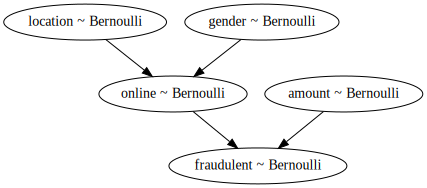

In [151]:
with model:
    pm.model_to_graphviz()

In [154]:
with pm.Model() as model:
        
    # Bernoulli random variables with priors
    gender = pm.Bernoulli('gender', 0.5)
    location = pm.Bernoulli('location', 0.2)

    # Bernoulli deterministic variable with conditional probability 
    online = pm.Bernoulli('online', tt.switch(tt.eq(location, 1), tt.switch(tt.eq(gender, 1), 0.25, 0.45),
                                                                  tt.switch(tt.eq(gender, 1), 0.3, 0.6)))

    # Bernoulli random variable with prior
    amount = pm.Normal('amount', mu = 300, sd = 100)

    # Bernoulli deterministic variable with conditional probability
    fraudulent = pm.Bernoulli('fraudulent', tt.switch(tt.eq(amount, 1), tt.switch(tt.eq(online, 1), 0.45, 0.2),
                                                                        tt.switch(tt.eq(online, 1), 0.1, 0.05)))

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>BinaryGibbsMetropolis: [gender, location, online, fraudulent]
>NUTS: [amount]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:06<00:00, 588.68draws/s]
C:\Users\willk\Anaconda3\envs\py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


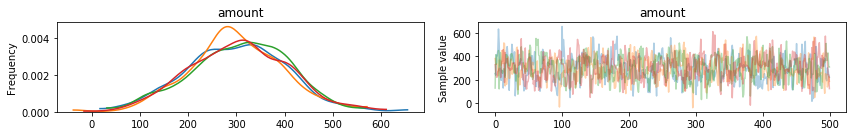

In [155]:
with model:
    trace = pm.sample()
    
pm.traceplot(trace, varnames=['amount']);

In [164]:
import theano

values = theano.shared(np.array([100, 150, 200, 250]))

In [176]:
with pm.Model() as model:
    c = pm.Categorical('c', [0.1, 0.2, 0.3, 0.4])
    value = values[c]
    value = pm.Deterministic('value_det', value)
    trace = pm.sample()

Multiprocess sampling (4 chains in 4 jobs)
CategoricalGibbsMetropolis: [c]
Sampling 4 chains: 100%|██████████| 4000/4000 [00:04<00:00, 976.73draws/s] 
C:\Users\willk\Anaconda3\envs\py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [177]:
trace['value_det'].mean()

200.825

In [178]:
trace['c'].mean()

2.0165

In [179]:
trace['value_det']

array([100, 150, 250, ..., 250, 100, 150])

In [167]:
value

Subtensor{int64}.0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DBA47066D8>,
      dtype=object)

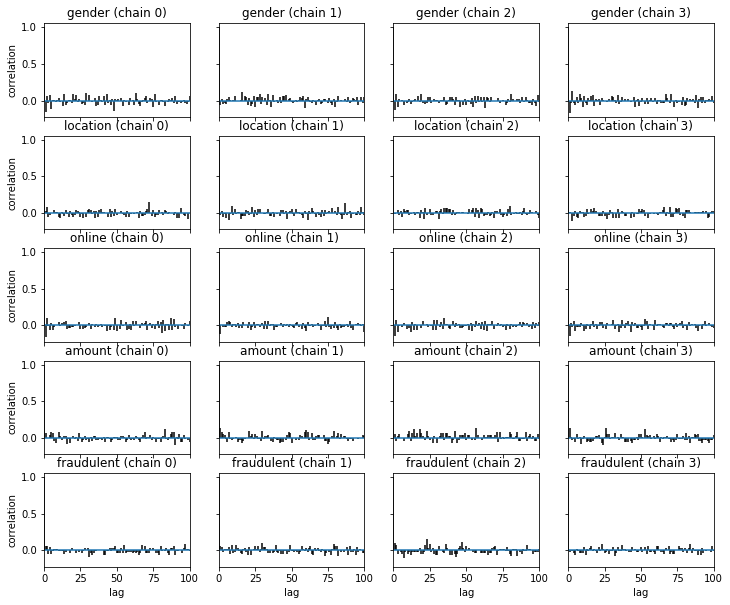

In [137]:
pm.autocorrplot(trace)

In [96]:
trace.varnames

['gender', 'location', 'online', 'amount', 'fraudulent_det']

In [99]:
model.free_RVs

[gender, location, online, amount]

In [98]:
model.deterministics

[fraudulent_det]

In [97]:
trace.get_sampler_stats('location')

KeyError: 'Unknown sampler statistic location'

In [84]:
trace['fraudulent_det'].mean()

0.1095

In [63]:
model.unobserved_RVs

[gender, location, online, amount, fraudulent]

In [ ]:
pm.Deterministic(

In [65]:
model.deterministics

[]

In [64]:
model.vars

[gender, location, online, amount, fraudulent]

In [62]:
model.disc_vars

[gender, location, online, amount, fraudulent]

In [2]:
def make_model(gender_obs=None, location_obs=None, online_obs=None,
               amount_obs=None, fraudulent_obs=None):
    """Make a model for the fraudulent transaction problem."""
    
    with pm.Model() as model:
        
        # Bernoulli random variables with priors
        gender = pm.Bernoulli('gender', 0.5, observed = gender_obs)
        location = pm.Bernoulli('location', 0.2, observed = location_obs)
        
        # Bernoulli deterministic variable with conditional probability 
        online = pm.Bernoulli('online', tt.switch(tt.eq(location, 1), tt.switch(tt.eq(gender, 1), 0.25, 0.45),
                                                                      tt.switch(tt.eq(gender, 1), 0.3, 0.6)),
                              observed = online_obs)
        
        # Bernoulli random variable with prior
        amount = pm.Bernoulli('amount', 0.1, observed = amount_obs)
        
        # Bernoulli deterministic variable with conditional probability
        fraudulent = pm.Bernoulli('fraudulent', tt.switch(tt.eq(amount, 1), tt.switch(tt.eq(online, 1), 0.45, 0.2),
                                                                            tt.switch(tt.eq(online, 1), 0.1, 0.05)),
                                  observed = fraudulent_obs)
        return model

In [3]:
def sample_model(model):
    """Sample from a pymc3 model"""
    
    with model:
        trace = pm.sample(draws=N_SAMPLES, chains=N_CHAINS)
    return trace

In [26]:
fraud_model = make_model()
fraud_trace = sample_model(fraud_model)

Multiprocess sampling (3 chains in 4 jobs)
BinaryGibbsMetropolis: [gender, location, online, amount, fraudulent]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:01<00:00, 2250.20draws/s]
C:\Users\willk\Anaconda3\envs\py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [28]:
fraud_trace['fraudulent'].mean()

0.099

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DB9FBE2EB8>,
      dtype=object)

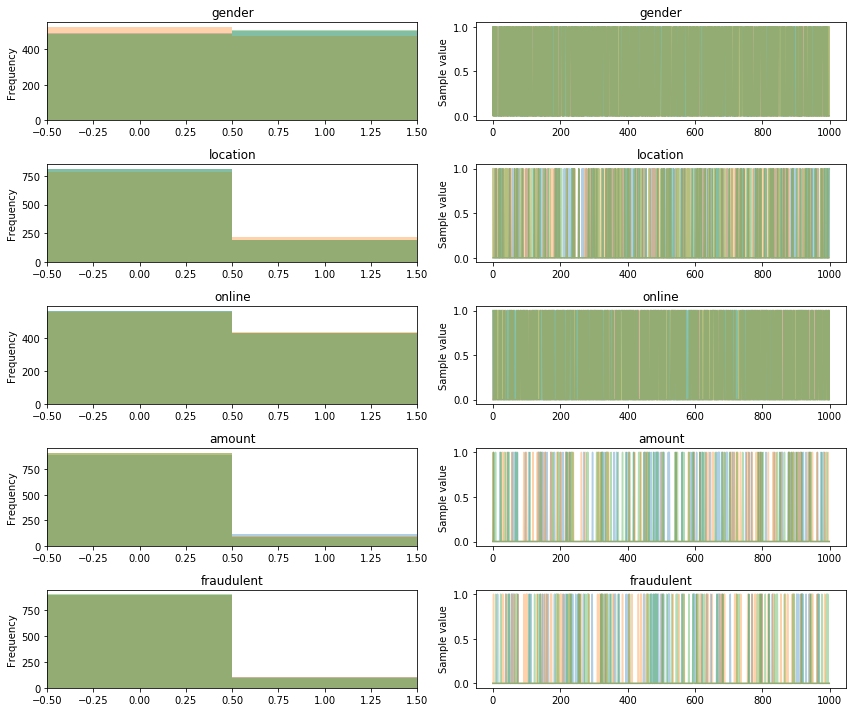

In [8]:
pm.traceplot(fraud_trace)

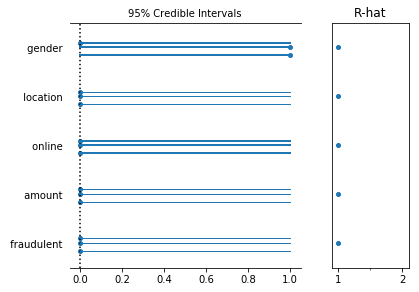

In [9]:
pm.forestplot(fraud_trace)

In [7]:
fraud_trace['gender'].mean()

0.49666666666666665

In [29]:
fraud_trace['online'].mean()

0.43833333333333335

In [30]:
fraud_model = make_model(amount_obs = 0)
fraud_trace = sample_model(fraud_model)

Multiprocess sampling (3 chains in 4 jobs)
BinaryGibbsMetropolis: [gender, location, online, fraudulent]
Sampling 3 chains: 100%|██████████| 4500/4500 [00:01<00:00, 2400.14draws/s]
C:\Users\willk\Anaconda3\envs\py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


In [31]:
fraud_trace['fraudulent'].mean()

0.074

In [ ]:
pm.traceplot(fraud_trace)

In [ ]:
p_sanfran = fraud_trace['location']
p_sanfran.mean()

In [ ]:
p_female = fraud_trace['gender']
p_female.mean()

In [ ]:
p_fraud = fraud_trace['fraudulent']
p_fraud.mean()

# Bayesian Linear Regression

We can also use Probabilistic Programming to perform Bayesian Linear Regression

In ordinary least squares regression, the data generating process is:

$$y = \beta * X + \epsilon$$

In Bayesian Linear Regression, the data generating process is a distribution:

$$ y \sim N(\mu, (\sigma) ^ 2)$$
$$\mu = \alpha + \beta * X$$

Where $\beta$ and X are matrices representing the weights and features respectively and $\alpha$ is the intercept.


In [ ]:
from pymc3 import GLM

In [37]:
data = pd.read_csv('../data/bike-sharing/day.csv', parse_dates = ['dteday']).set_index('dteday')
data['date'] = data.index
data.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,date
dteday,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011-01-01
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011-01-02
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011-01-03
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011-01-04
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011-01-05


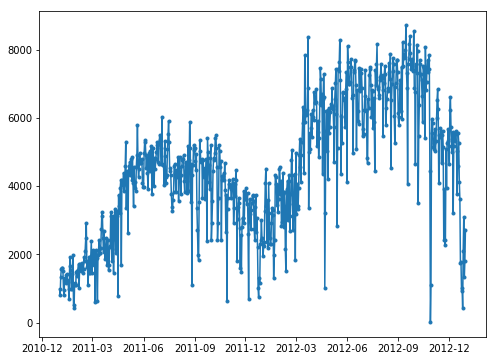

In [43]:
plt.figure(figsize = (8, 6))
plt.plot(data['date'], data['cnt'], marker = '.');

In [44]:
data['day'] = (data.index - data.index[0]).days
data.head()

,instant,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt,date,day
dteday,,,,,,,,,,,,,,,,,
2011-01-01,1,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985,2011-01-01,0
2011-01-02,2,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801,2011-01-02,1
2011-01-03,3,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349,2011-01-03,2
2011-01-04,4,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562,2011-01-04,3
2011-01-05,5,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600,2011-01-05,4


([<matplotlib.axis.XTick at 0x1db9f7830f0>,
 <a list of 731 Text xticklabel objects>)

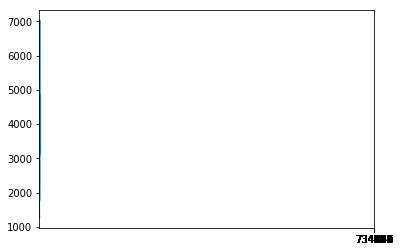

In [51]:

p = np.polyfit(data['day'], data['cnt'], 8)
y = np.polyval(p, data['day'])
plt.plot(y)
plt.xticks(data.index)

TypeError: reduction operation 'mean' not allowed for this dtype

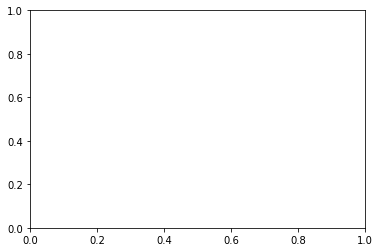

In [53]:
import seaborn as sns


sns.regplot('date', 'cnt', data, fit_reg = False);

In [54]:
formula = ('cnt ~ day + season + mnth + holiday + weekday +  workingday + weathersit + atemp + windspeed')

In [57]:
from pymc3 import GLM
with pm.Model() as bike_model:
    GLM.from_formula(formula, data)
    start = pm.find_MAP()
    trace = pm.sample(tune=1000, njobs=-1, start = start)

logp = -6,094.9, ||grad|| = 0.047079: 100%|██████████| 854/854 [00:00<00:00, 1223.78it/s]    
Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [sd, windspeed, atemp, weathersit, workingday, weekday, holiday, mnth, season, day, Intercept]
100%|██████████| 1500/1500 [00:10<00:00, 147.15it/s]
C:\Users\willk\Anaconda3\envs\py36\lib\site-packages\mkl_fft\_numpy_fft.py:1044: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  output = mkl_fft.rfftn_numpy(a, s, axes)


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x000001DBA4262470>,
      dtype=object)

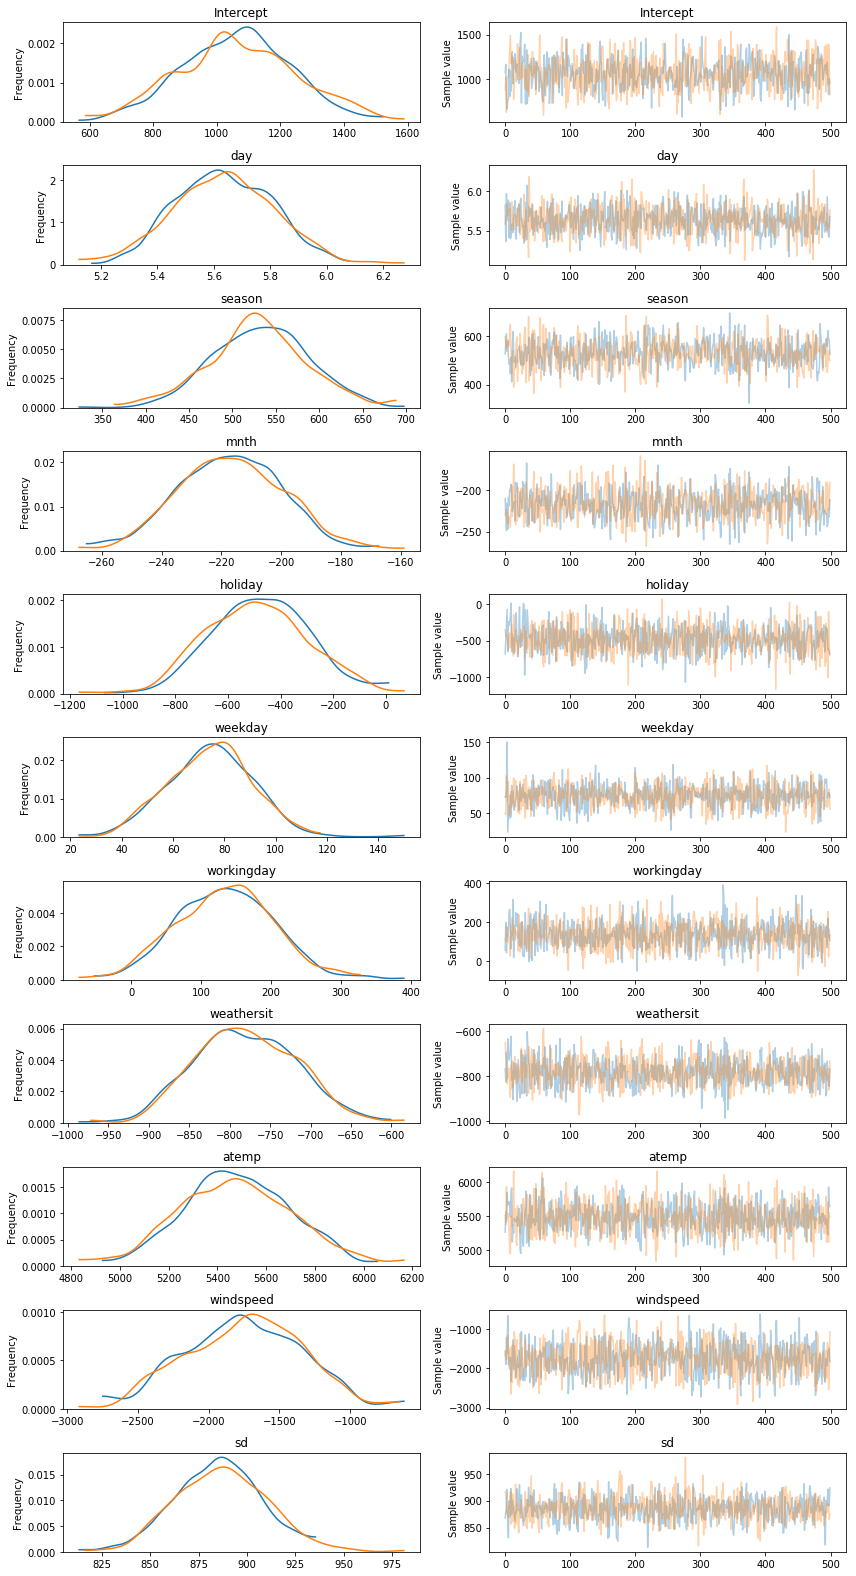

In [58]:
pm.traceplot(trace)

In [ ]:
def lm(value, sample):
    prediction = sample['Intercept']
    for var in sample.keys():
        prediction += sample[var] * value
    return prediction

In [ ]:
trace['season'] * data['season'][0]

In [ ]:
len(trace['season'])

In [ ]:
row.index

In [ ]:
trace.varnames

In [ ]:
estimates = []
days = []
for i, (day, row) in enumerate(data.iterrows()):
    estimate = trace['Intercept']
    for var in row.index:
        if var in trace.varnames:
            estimate += trace[var] * row[var]
    estimates.append(estimate)
    days.append(day for _ in range(len(trace[var])))
    print(f'{round(100 * (i / len(data)), 2)}% complete.', end = '\r')

In [ ]:
len(days)

In [ ]:
len(estimates)

In [ ]:
est = pd.DataFrame(estimates)
est.index = data.index
est.head()

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
fig, ax = plt.subplots(figsize = (10, 10))
data['cnt'].plot(linewidth = 2, linestyle = '--', color = 'k', ax = ax);
est.plot(legend = None, ax = ax);

In [ ]:
data['upper'] = np.percentile(est, 95, axis = 1)
data['lower'] = np.percentile(est, 5, axis = 1)


In [ ]:
data.head()

In [ ]:
plt.figure(figsize = (10, 10))
plt.fill_between(x = data.index, y1=data['lower'], alpha = 10, y2 = data['upper'],step = 'mid')

In [ ]:
fig, ax = plt.subplots(figsize = (10, 10))
data['cnt'].plot(ax = ax, label = 'actual')
data['lower'].plot(ax = ax, label = 'lower')
data['upper'].plot(ax = ax, label = 'upper')
plt.legend();

In [ ]:
estimate.shape

In [ ]:
len(data)

In [ ]:
pm.plots.plot_posterior(trace, varnames = ['cnt']);